# Forward Neural network

The forward model is a 
resnet model. 

## Import modules

In [15]:
#!pip install tables

In [16]:
import os
import math
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

os.environ["KERAS_BACKEND"] = "tensorflow"

## Set dynamic GPU memory growth

In [17]:
# Check if GPU available 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")


GPU is available and set to memory growth mode.


## Load preprocessed data

In [18]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()


In [19]:
X_train[0].shape

(16,)

### Custom Resnet model

#### Resblock

In [20]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable() # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()

        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()

        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }


#### Full resnet

In [21]:
N_rb = 4 # Nr of resblocks per size

def create_custom_resnet_model(input_shape):
    inputs = keras.layers.Input(shape=(input_shape,))

    x = inputs
    # dense layer for reshaping
    x = keras.layers.Dense(8192)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)
    x = keras.layers.Dense(4096)(x)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)

    x = keras.layers.Dense(256 * 8)(x)  # Adjust output size for reshaping (8 final length x 256 filters)
    x = keras.layers.LeakyReLU(negative_slope=0.01)(x)

    # Reshape to match the shape for Conv1D
    x = keras.layers.Reshape((8, 256))(x)  # Starting with length 8 and 256 filters

    # residual blocks followed by upsampling to reach final output size 
    for i in range(N_rb):
        x = ResBlock1D(filters=256)(x)
    x = keras.layers.UpSampling1D(size=2)(x)                     # Upsample to length 16
    
    for i in range(N_rb):
        # first block is a convblock (if i==0)
        x = ResBlock1D(filters=256, convblock=(i==0))(x)
    x = keras.layers.UpSampling1D(size=2)(x)                     # Upsample to length 32
    
    for i in range(N_rb):
        x = ResBlock1D(filters=128, convblock=(i==0))(x)
    x = keras.layers.UpSampling1D(size=2)(x)                     # Upsample to length 64

    # Final data size reached. no upsampling after resblock
    for i in range(N_rb):
        x = ResBlock1D(filters=128, convblock=(i==0))(x)
    
    # Two output channels (forward and backward scattering)
    out_scat = keras.layers.Conv1D(2, kernel_size=1)(x)  # linear output activation

    # Define the model
    model = keras.Model(inputs=inputs, outputs=out_scat)


    return model

In [22]:
model_for_summary = create_custom_resnet_model(X_train.shape[1])
model_for_summary.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_16 (ResBlock1D)     │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_17 (ResBlock1D)     │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_18 (ResBlock1D)     │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_19 (ResBlock1D)     │ (None, 8, 256)         │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_20 (ResBlock1D)     │ (None, 16, 256)        │       461,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_21 (ResBlock1D)     │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_22 (ResBlock1D)     │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_23 (ResBlock1D)     │ (None, 16, 256)        │       395,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_24 (ResBlock1D)     │ (None, 32, 128)        │       181,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_25 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_26 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_27 (ResBlock1D)     │ (None, 32, 128)        │        99,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_28 (ResBlock1D)     │ (None, 64, 128)        │       116,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block1d_29 (ResBlock1D)     │ (None, 64, 128)        │        99,58

 Total params: 46,215,938 (176.30 MB)

 Trainable params: 46,203,650 (176.25 MB)

 Non-trainable params: 12,288 (48.00 KB)

## Train the model

### Learning rate scheduler

In [23]:
# Define custom callback to format logging
class CustomCallbackStatusPrint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}/{self.params['epochs']}")
        for key, value in logs.items():
            print(f"{key}: {value:.6f}")

# Define step decay schedule
def step_decay_schedule(initial_lr, decay_factor, step_size):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** math.floor(epoch/step_size))
        return new_lr
    
    return keras.callbacks.LearningRateScheduler(schedule)



### Hybrid Training (Decay learning and Increase leanring rate)

In [ ]:
################################################################
##################### Hybrid Scheduler #########################
################################################################

# Custom Training with train_on_batch
def train_on_batch_scheduler(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    initial_batch_size,
    max_batch_size,
    initial_lr,
    step_size,
    epochs,
    decay_factor,
    patience,
):
    batch_size = initial_batch_size
    current_lr = initial_lr
    history = {"loss": [], "val_loss": []}

    best_val_loss = np.inf  # Initialize the best validation loss
    patience_counter = 0  # Early stopping counter

    # Loop through epochs
    for epoch in range(epochs):
        print(
            f"\nEpoch {epoch+1} - Training with Batch Size: {batch_size}, Learning Rate: {current_lr:.6f}"
        )

        # Update learning rate dynamically
        model.optimizer.learning_rate.assign(
            float(current_lr)
        )  # ssign current leanring rate
        epoch_loss = []

        # Train in batches
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            loss = model.train_on_batch(X_batch, y_batch)  # use train_on_batch
            epoch_loss.append(loss)

        avg_loss = np.mean(epoch_loss)
        val_loss = model.evaluate(X_val, y_val, verbose=0)

        # Print training and validation loss
        print(
            f"Epoch {epoch+1}: Loss = {avg_loss:.6f}, Validation Loss = {val_loss:.6f}"
        )

        # Log losses for later analysis
        history["loss"].append(avg_loss)
        history["val_loss"].append(val_loss)

        # Check for Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"[DEBUG] Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("[INFO] Early stopping triggered!")
            break

        # Adjust batch size and learning rate after every `step_size` epochs
        if (epoch + 1) % step_size == 0:
            batch_size = min(batch_size * 2, max_batch_size)
            current_lr *= decay_factor  # Decay learning rate
            print(
                f"[DEBUG] Updated Batch Size: {batch_size}, Learning Rate: {current_lr:.6f}"
            )

    return history

### instantiate the model

In [25]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

model = create_custom_resnet_model(X_train_new.shape[1])

### Train

In [26]:
# Parameters
initial_batch_size = 2
max_batch_size = 256
initial_lr = 0.0001
decay_factor = 0.5
step_size = 15
epochs = 300
validation_split = 0.1
patience = 20  # Early stopping patience

# Compile Model
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss="mse")

################################################################
##################### Hybrid Scheduler #########################
################################################################
# Train Model Using Custom Scheduler
history = train_on_batch_scheduler(
    model, X_train, y_train, X_val, y_val, 
    initial_batch_size, max_batch_size, initial_lr, step_size, epochs, decay_factor, patience
)


# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history["loss"], color="#06346B", label="Training Loss")
plt.plot(history["val_loss"], color="#E34E5A", label="Validation Loss")
plt.title("Hybrid Mode with Early Stopping: Training Loss vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1 - Training with Batch Size: 2, Learning Rate: 0.000100


I0000 00:00:1740584829.065505  100743 service.cc:148] XLA service 0x4ec72290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740584829.072501  100743 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-26 16:47:09.431866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740584830.710902  100743 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740584835.924148  100743 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: Loss = 0.083329, Validation Loss = 0.013194

Epoch 2 - Training with Batch Size: 2, Learning Rate: 0.000100


KeyboardInterrupt: 

### Save

In [28]:
# - save the model
model_filename = "models/resnet_Mie_predictor.keras"
model.save(model_filename)

# - save the training history 
history_save_path = os.path.splitext(model_filename)[0] + "_hist.pkl"
with open(history_save_path, "wb") as f:
    pickle.dump(history, f)


### plot training convergence

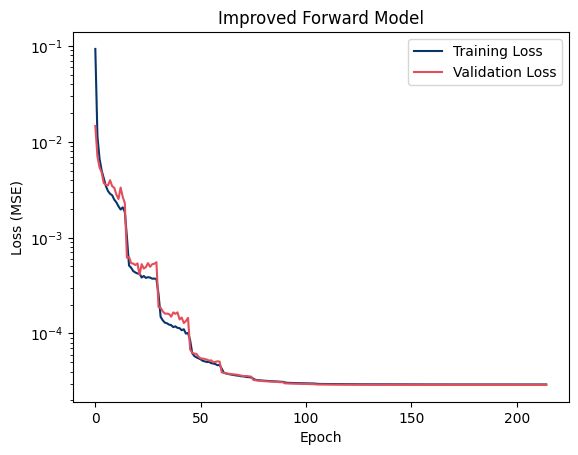

In [ ]:

# - plot the training and validation loss
plt.plot(history["loss"], color="#06346B", label="Training Loss")
plt.plot(history["val_loss"], color="#E34E5A", label="Validation Loss")
plt.title("Improved Forward Model")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.legend()
plt.show()
